## Report for Project "Collaboration and Competition"
### 1. Problem Statement
In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. **Each agent receives its own, local observation.**  Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

The task is episodic, and in order to solve the environment, the agents must get an **average scores** of **+0.5** (over 100 consecutive episodes, after taking the maximum over both agents). Specifically,

- After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
- This yields a single **score** for each episode.

The single **D**eep **D**eterministic **P**olicy **G**radient [agent](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py) and [model](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/model.py) are reused as starting point and adapted to **2** DDPG-agents for the two players which are trained by sharing the experience buffer.
#### Actor-Critic Method
Value-based methods, such like Deep Q Network (DQN), are helping the agent to find a optimal state action value and the goal is to maxmimize the cumulative rewards. During the learning process, the agent will firstly estimate the expected return using a target DQN and the current return using a local DQN. After learning, the weights of local DQN are copied to the target DQN. As a result, the estimation by target is depending on the previous learning step. So, the value-based approach is bias.

On the other hand, the policy-based methods, like DDPG, are training the agent with state-action pair using gradient ascent. The goal is thus to directly find a optimal policy. Using the policy-based methods, the learning is less bias but with more variance. Actor-Critic method leverage the stengths of both policy-based and value-based methods, with more efficiency on the learning process, while the agent trained by this method is more stable.
#### Replay buffer
After each step, the tuple $(s_t, a_t, r_t, s_{i+1})$ are stored to a buffer called "experience", which are uniformly sampled to get a minibatch for the next learning. This uniformly sampling breaks the correlations of each state action transition.
#### Soft update
The weights of target networks $\theta'$ are updated by slowly tracking the learned network $\theta$.
$$
\theta' \leftarrow \tau \theta + (1 - \tau)\theta' \ \ \ {with} \ \tau \ll 1.
$$

### 2. Model architecture
The model for both **Actor** and **Critic** consists of 3 fully connected layers with **128** hidden nodes for the first and second layer. **Batch normalization** is used for increasing the efficiency, while **clipping gradient** on training to avoid gradient explosion

### 3. Hyperparameters of Agent
On the first training, the average scores slowly increased but could not reach the target score of 0.5, the maximum score was only $\approx$0.1, which the training took much long. Seeing that problem, I firstly reduced the buffer size, since some not important experiences are stored there, e.g. the first 100 episode, which are randomly sampled and don't get more scores. 

And I introduced the parameter to train the agents **10** times for every **5** time steps, to stabilize the average scores while garanteeing the training efficiency. 

To trade off the exploration and exploitation, *EPSILON* is set initially and decayed by a factor *EPSILON_DECAY*, the benifit is to start the training with exploring more possible actions in the environment, since the agent didn't get much experience yet, but during the training with more episodes, the agent is more experienced, decaying epsilon can help agent exploit more.

The next section will show, training the agents with the those parameters has achieved a really good result.

In [1]:
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0.0      # L2 weight decay

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size

LEARN_EVERY = 5
LEARN_NUM = 10

EPSILON = 1.0
EPSILON_DECAY = 0.999

### 4. Training Result
Run the following cells, it can be seen that, we solved the problem after **d** episodes and got a maximum average score of **1.24** over 100 episodes.

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

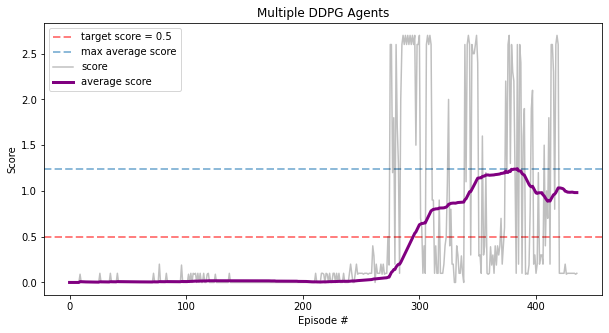

- The target average score (over 100 episodes) is got after 295 episodes.
- The maximum average score 1.24 (over 100 episodes) is got after 384 episodes.


In [16]:
scores_path = './scores.pickle'
scores_mean_path = './scores_mean.pickle'
with open(scores_path, 'rb') as f:
    scores_result = pickle.load(f)
with open(scores_mean_path, 'rb') as f:
    scores_mean_result = pickle.load(f)

fig, ax = plt.subplots(1, 1, figsize=[10, 5])

ax.axhline(0.5, c="red", ls='--', linewidth=2, alpha=0.5, label='target score = {}'.format(0.5))
ax.axhline(np.max(scores_mean_result), ls='--', linewidth=2, alpha=0.5, label='max average score')
ax.plot(scores_result, "-", c="black", alpha=0.25, label='score')
ax.plot(scores_mean_result, "-", c="purple", linewidth=3, label='average score')

ax.set_xlabel("Episode #")
ax.set_ylabel("Score")
ax.set_title("Multiple DDPG Agents")
ax.legend()

plt.show()

idx_first_target_score = [i for i, score in enumerate(scores_mean_result) if score >= 0.5][0]
print("- The target average score (over 100 episodes) is got after {} episodes.".format(idx_first_target_score))
print("- The maximum average score {:.2f} (over 100 episodes) is got after {} episodes.".format(np.max(scores_mean_result), np.argmax(scores_mean_result)))

### 5. Watch the result in Unity

changing the path of the environment and running the block, the result can be watched in Unity.

In [4]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
from ddpg_agent import Agents

In [5]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents, action and state size
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [6]:
agent = Agents(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=10)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location='cpu'))

In [7]:
env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False)       # select an action (for each agent)

    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 2.600000038743019


In [8]:
env.close()

### 6. Further Works
The following works could be done in the future:
1. Using Prioritized Experience Replay to store and sample experiences
2. Using learning rate scheduler to improve the training performance
3. Try DDPG agents in more compilcated environment, e.g. Soccers